<a href="https://colab.research.google.com/github/prabhudc/DQ/blob/master/kNN_Regression_Car_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


# Predicting car prices

Predict a car's price based on its technical specicification. The data is source form the UCI ML dataset repository

## Preperation

In [55]:
# Read in the dataset
df_cars = pd.read_csv("/content/drive/My Drive/DataScience/files/imports-85.data",header=None)
# Headers copied from the UCI DataSet Introduction page for the dataset
headers = ['symboling',	'normalized-losses',	'make',	'fuel-type',	'aspiration',	'num-of-doors',	'body-style',	'drive-wheels',	'engine-location',	'wheel-base',	'length',	'width',	'height',	'curb-weight',	'engine-type',	'num-of-cylinders',	'engine-size',	'fuel-system',	'bore',	'stroke',	'compression-ratio',	'horsepower',	'peak-rpm',	'city-mpg',	'highway-mpg',	'price']
df_cars.columns = headers
print(df_cars.shape)

(205, 26)


The dataset has 205 observation with 26 variables. Lets look at a sample of records.

In [56]:
df_cars.sample(n=5)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.00,154,5000,19,26,16500
152,1,74,toyota,gas,std,four,hatchback,fwd,front,95.7,158.7,63.6,54.5,2015,ohc,four,92,2bbl,3.05,3.03,9.00,62,4800,31,38,6488
120,1,154,plymouth,gas,std,four,hatchback,fwd,front,93.7,157.3,63.8,50.6,1967,ohc,four,90,2bbl,2.97,3.23,9.40,68,5500,31,38,6229
21,1,118,dodge,gas,std,two,hatchback,fwd,front,93.7,157.3,63.8,50.8,1876,ohc,four,90,2bbl,2.97,3.23,9.41,68,5500,37,41,5572
75,1,?,mercury,gas,turbo,two,hatchback,rwd,front,102.7,178.4,68.0,54.8,2910,ohc,four,140,mpfi,3.78,3.12,8.00,175,5000,19,24,16503


The objective of the project is to predict the prices and hence the column price is the target. As we would be using kNN Regression, we are only interested in numeric attributes.

symboling, normalized-losses, wheel-base, length, width, height, curb-weight,  engine-size, bore, stroke, compression-ratio, horsepower, peak-rpm, city-mpg, hiehgway-mpg.

Let's drop the non-numeric variables

In [57]:
drop_cols = ['make','fuel-type','aspiration','num-of-doors', 'body-style', 'drive-wheels', 'engine-location' ,'num-of-cylinders', 'fuel-system','engine-type']
df_cars.drop( columns=drop_cols, inplace=True)
df_cars.sample(n=5)

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
87,1,125,96.3,172.4,65.4,51.6,2403,110,3.17,3.46,7.5,116,5500,23,30,9279
9,0,?,99.5,178.2,67.9,52.0,3053,131,3.13,3.40,7.0,160,5500,16,22,?
43,0,?,94.3,170.7,61.8,53.5,2337,111,3.31,3.23,8.5,78,4800,24,29,6785
147,0,89,97.0,173.5,65.4,53.0,2455,108,3.62,2.64,9.0,94,5200,25,31,10198
195,-1,74,104.3,188.8,67.2,57.5,3034,141,3.78,3.15,9.5,114,5400,23,28,13415


Having nulls would pose a problem for the prediction function. Lets look at how reliable the variables are  

In [58]:
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   wheel-base         205 non-null    float64
 3   length             205 non-null    float64
 4   width              205 non-null    float64
 5   height             205 non-null    float64
 6   curb-weight        205 non-null    int64  
 7   engine-size        205 non-null    int64  
 8   bore               205 non-null    object 
 9   stroke             205 non-null    object 
 10  compression-ratio  205 non-null    float64
 11  horsepower         205 non-null    object 
 12  peak-rpm           205 non-null    object 
 13  city-mpg           205 non-null    int64  
 14  highway-mpg        205 non-null    int64  
 15  price              205 non-null    object 
dtypes: float64(5), int64(5), o

Indeed, there are no nulls but let's look at the values closely

In [59]:
df_cars['normalized-losses'].value_counts().head()

?      41
161    11
91      8
150     7
134     6
Name: normalized-losses, dtype: int64

As can be seen, the dataset has converted all nulls to the question-mark symbol and hence we didnt see them. Lets replace all question=marks with null and check for nulls again.

In [60]:
df_cars.replace(to_replace='?',value=np.nan,inplace=True)
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  164 non-null    object 
 2   wheel-base         205 non-null    float64
 3   length             205 non-null    float64
 4   width              205 non-null    float64
 5   height             205 non-null    float64
 6   curb-weight        205 non-null    int64  
 7   engine-size        205 non-null    int64  
 8   bore               201 non-null    object 
 9   stroke             201 non-null    object 
 10  compression-ratio  205 non-null    float64
 11  horsepower         203 non-null    object 
 12  peak-rpm           203 non-null    object 
 13  city-mpg           205 non-null    int64  
 14  highway-mpg        205 non-null    int64  
 15  price              201 non-null    object 
dtypes: float64(5), int64(5), o

Sum of the fields do have nulls and we will handle them separately.

* normalized-losses : About 20% of the records are nulls. It wouldn't be wise to drop the rows, but we will chose to drop the column.
* bore : Four records are missing values. We will drop the rows.
* stroke : Four records are missing values. We will drop the rows.
* horsepower : Two records are missing values. We will drop the rows.
* peak-rpm : Two records are missing values. We will drop the rows.
* price : This our target variable and we would need it for learning the model and hence we can't have nulls in it. We drop these rows too.

In [61]:
df_cars.drop(columns=['normalized-losses'],inplace=True)
df_cars.dropna(inplace=True)
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 0 to 204
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          195 non-null    int64  
 1   wheel-base         195 non-null    float64
 2   length             195 non-null    float64
 3   width              195 non-null    float64
 4   height             195 non-null    float64
 5   curb-weight        195 non-null    int64  
 6   engine-size        195 non-null    int64  
 7   bore               195 non-null    object 
 8   stroke             195 non-null    object 
 9   compression-ratio  195 non-null    float64
 10  horsepower         195 non-null    object 
 11  peak-rpm           195 non-null    object 
 12  city-mpg           195 non-null    int64  
 13  highway-mpg        195 non-null    int64  
 14  price              195 non-null    object 
dtypes: float64(5), int64(5), object(5)
memory usage: 24.4+ KB


We've lost 10 records in all and that is not too bad for quality prediction model

Some of the fields are of object-type. Let's covert all of them float

In [62]:
df_cars = df_cars.astype(float).copy()

To To avoid the model from being biased towards some variables, lets normalize all of the variables

In [63]:
df_cars = (df_cars - df_cars.min())/(df_cars.max() - df_cars.min()  ).copy()
df_cars.head()

,symboling,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,1.0,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,0.207959
1,1.0,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,0.282558
2,0.6,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.1250,0.495327,0.346939,0.166667,0.263158,0.282558
3,0.8,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.1875,0.252336,0.551020,0.305556,0.368421,0.219254
4,0.8,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.0625,0.313084,0.551020,0.138889,0.157895,0.306142


## Modelling

Lets begin by defining a function for the univariate model and determin how each column performs at predicting the target variables

In [64]:
def knn_train_test(var_col, tgt_col, df,k=5 ):
  # Create train/test splits
  X_train, X_test = train_test_split(df,test_size=0.2, train_size=0.8,shuffle=True)
  # instansiate the predictor model
  knn = KNeighborsRegressor( n_neighbors=k)
  # Create selections for the training set  
  X = X_train[var_col]
  ones = np.ones_like(X)
  X.reset_index(drop=True,inplace=True)
  X = pd.concat([X,pd.Series(ones)],axis=1)
  y = X_train[tgt_col]
  # Fit the model
  knn.fit(X,y)
  # Perform prediction on test set
  X = X_test[var_col]
  ones = pd.Series(np.ones_like(X))
  X.reset_index(drop=True,inplace=True)
  X = pd.concat([X,ones],axis=1)
  predictions = knn.predict(X)
  # Assess performance of the model
  mse = mean_squared_error(predictions,X_test[tgt_col])
  rmse = np.sqrt(mse)
  return rmse

In [65]:
column_rmses = dict()
for col in df_cars.columns:
  if col != 'price':
    column_rmses[col] = knn_train_test(col,'price',df_cars,5)
# Print the column-level RMSEs for k = 5
column_rmses

{'bore': 0.1885558924223286,
 'city-mpg': 0.10420477174086994,
 'compression-ratio': 0.20098626916732665,
 'curb-weight': 0.09646315608757956,
 'engine-size': 0.06715822693637338,
 'height': 0.1864075128979825,
 'highway-mpg': 0.12743969872082633,
 'horsepower': 0.1440042083430633,
 'length': 0.10367679269249655,
 'peak-rpm': 0.16373840379905308,
 'stroke': 0.17602045855041618,
 'symboling': 0.19967253880688735,
 'wheel-base': 0.11804253989769115,
 'width': 0.16423317731161352}

Evidently the curb-weight, horsepower, engine-size, miles per gallon have the strongest correlation with the price.

Let us change the layout that it can be plotted easily

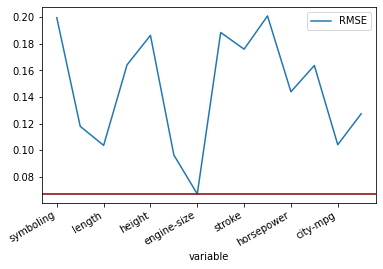

In [66]:
df_rmses = pd.DataFrame([[col,column_rmses[col]]  for col in column_rmses], columns=['variable','RMSE'])
df_rmses.set_index(keys='variable',inplace=True)
# df_rmses.plot.bar()
df_rmses.plot.line(subplots=True)
plt.xlabel=df_rmses.index.to_list()
plt.axhline(y=df_rmses.min()[0],color='maroon')
plt.show()

Now we would like to adjust the hyper-parameter and look at the outcome.

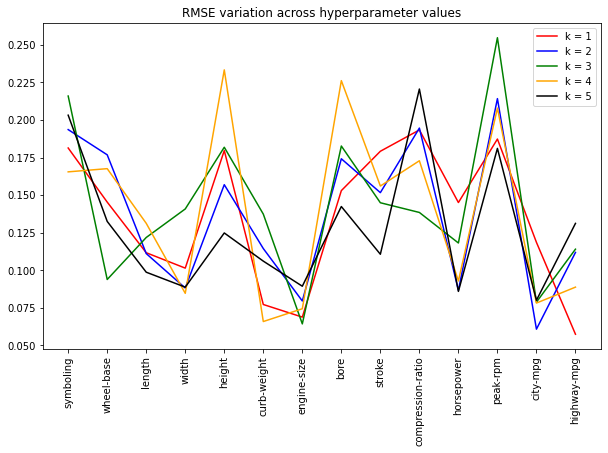

In [67]:
# Initialize a matplotlib figure object
fig = plt.figure(figsize=(10,6))
# Create valrable for the colors
chart_colors = ["red","blue","green","orange","black"]

# Loop over the hyperparameter possibilites
for k in np.arange(1,6):
  column_rmses = dict()
  for col in df_cars.columns:
    if col != 'price':
      column_rmses[col] = knn_train_test(col,'price',df_cars)
  x_labels = [col for col in column_rmses]
  y_vals = [column_rmses[col] for col in column_rmses]
  plt.plot(x_labels,y_vals,color=chart_colors[k-1] ,label="k = " + str(k))
  
plt.legend(loc="upper right")
plt.xticks(rotation=90)
plt.title("RMSE variation across hyperparameter values")
plt.show()

Let's enhance the modelling function with the flexibility to chose the columns

In [68]:
def knn_train_test(var_cols, tgt_col, df,k=5 ):
  # Create train/test splits
  X_train, X_test = train_test_split(df,test_size=0.2, train_size=0.8,shuffle=True)
  # instansiate the predictor model
  knn = KNeighborsRegressor( n_neighbors=k)
  # Create selections for the training set  
  X = X_train[var_cols]
  if len(var_cols) == 1:
    ones = np.ones_like(X)
    X.reset_index(drop=True,inplace=True)
    X = pd.concat([X,pd.Series(ones)],axis=1)
  y = X_train[tgt_col]
  # Fit the model
  knn.fit(X,y)
  # Perform prediction on test set
  X = X_test[var_cols]
  if len(var_cols) == 1:
    ones = pd.Series(np.ones_like(X))
    X.reset_index(drop=True,inplace=True)
    X = pd.concat([X,ones],axis=1)
  predictions = knn.predict(X)
  # Assess performance of the model
  mse = mean_squared_error(predictions,X_test[tgt_col])
  rmse = np.sqrt(mse)
  return rmse

* All-columns and k = default(5)

In [69]:
rmses = []
# All columns
cols = df_cars.columns.to_list()[:-1]
rmses.append(knn_train_test (cols,'price',df_cars))
# Best 2 : engine-size and horse-power
cols = ['engine-size','horsepower']
rmses.append(knn_train_test (cols,'price',df_cars))
# Best 3 : engine-size, horse-power and city-mpg
cols = ['engine-size','horsepower','city-mpg']
rmses.append(knn_train_test (cols,'price',df_cars))
# Best 4 : engine-size, horse-power, city-mpg and width
cols = ['engine-size','horsepower','city-mpg','width']
rmses.append(knn_train_test (cols,'price',df_cars))
# Best 5 : engine-size, horse-power, city-mpg, width and wheel-base
cols = ['engine-size','horsepower','city-mpg','width','wheel-base']
rmses.append(knn_train_test (cols,'price',df_cars))

rmses

[0.11134820075016645,
 0.09462957048730161,
 0.03936343037432043,
 0.06969304923755,
 0.06541234524549504]

Define a generic function for plotting across k-values

In [70]:
def plot_rmses(kmax=5,cols=df_cars.columns.to_list()[:-1]):
  # Initialize a matplotlib figure object
  fig = plt.figure(figsize=(10,6))
  # Create valrable for the colors
  # chart_colors = ["red","blue","green","orange","black"]
  rmses = []
  # Loop over the hyperparameter possibilites
  for k in np.arange(1,kmax+1):
    column_rmses = dict()
    rmses.append(knn_train_test (cols,'price',df_cars,k))
  x_labels = np.arange(kmax) + 1
  y_vals = rmses   
  plt.plot(x_labels,y_vals)
  plt.xticks(rotation=90)
  plt.title("RMSE variation across hyperparameter values")
  plt.show()

The top-3 models from the above list are

* engine-size, horse-power, city-mpg, width and wheel-base
* engine-size, horse-power, city-mpg and width
* All columns

Hyperparameter tuning for model = (engine-size, horse-power, city-mpg, width and wheel-base)


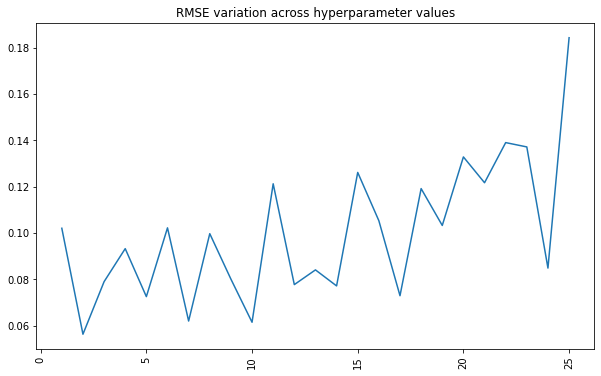

In [71]:
cols = ['engine-size','horsepower','city-mpg','width','wheel-base']
plot_rmses(25,cols)

Hyperparameter tuning for model = (engine-size, horse-power, city-mpg and width)

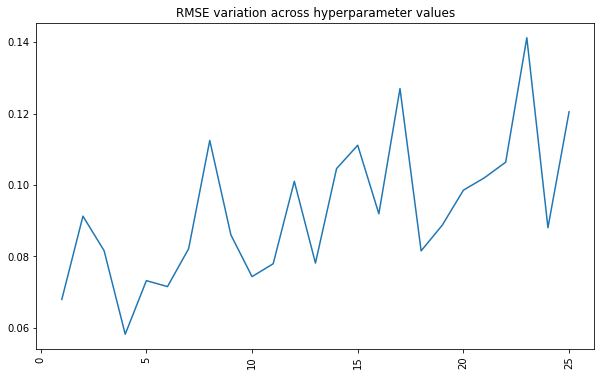

In [72]:
cols = ['engine-size','horsepower','city-mpg','width']
plot_rmses(25,cols)

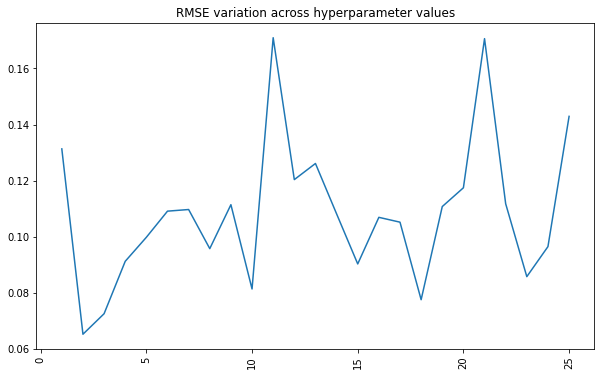

In [73]:
cols = df_cars.columns.to_list()[:-1]
plot_rmses(25,cols)

The performance of the model across k-values vary signinficantly. This is because of the variance of the dataset. To arrive at a more reliable outcome, let us try applying cross-validation. We again modify our main modelling function to incorporate the cross-validation APIs.

In [86]:
# Modelling function
def knn_train_test(var_cols, tgt_col, df,k=5,folds=5 ):
  # Instantiate the kfold split function
  kf = KFold(n_splits=folds, shuffle=True, random_state=1)
  # instansiate the predictor model
  knn = KNeighborsRegressor( n_neighbors=k)
  # Create selections for the training set  
  X = df[var_cols]
  if len(var_cols) == 1:
    ones = np.ones_like(X)
    X.reset_index(drop=True,inplace=True)
    X = pd.concat([X,pd.Series(ones)],axis=1)
  y = df[tgt_col]
  # Fit the model
  mse = cross_val_score(estimator=knn, X=X, y=y, scoring='neg_mean_squared_error', cv=kf)*-1
  rmse = np.sqrt(mse)
  return rmse

# Plotting function
def plot_rmses(kmax=5,cols=df_cars.columns.to_list()[:-1],folds=5):
  # Initialize a matplotlib figure object
  fig = plt.figure(figsize=(10,6))
  # Create valrable for the colors
  # chart_colors = ["red","blue","green","orange","black"]
  rmses = []
  # Loop over the hyperparameter possibilites
  for k in np.arange(1,kmax+1):    
    rmses.append(np.mean(knn_train_test (cols,'price',df_cars,k,folds)))
  x_labels = np.arange(kmax) + 1
  y_vals = rmses  
  # print(rmses) 
  plt.plot(x_labels,y_vals)
  plt.xticks(rotation=90)
  
  plt.title("RMSE variation across hyperparameter values")
  plt.show()

Hyperparameter tuning with cross-validation for model = (engine-size, horse-power, city-mpg, width and wheel-base)


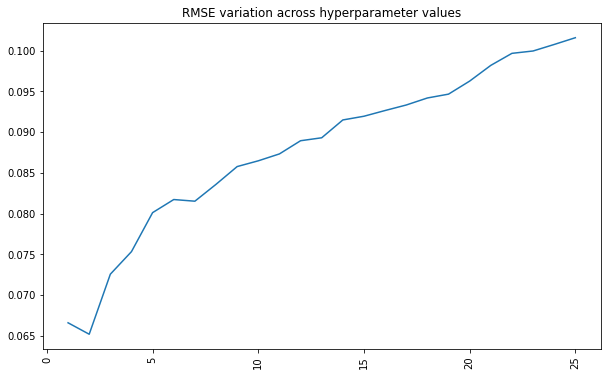

In [92]:
cols = ['engine-size','horsepower','city-mpg','width','wheel-base']
plot_rmses(25,cols,folds=20)

Hyperparameter tuning with cross-validation for model = (engine-size, horse-power, city-mpg, width)


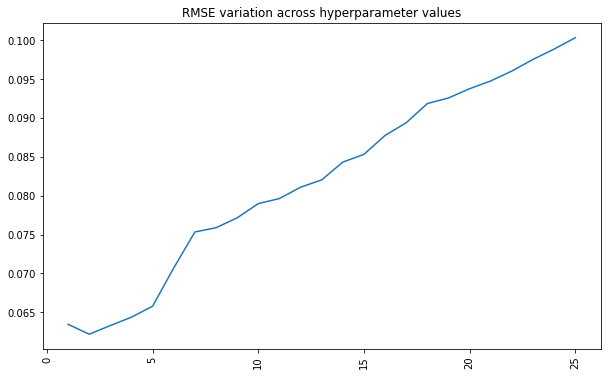

In [93]:
cols = ['engine-size','horsepower','city-mpg','width']
plot_rmses(25,cols,folds=20)

Hyperparameter tuning with cross-validation for full model


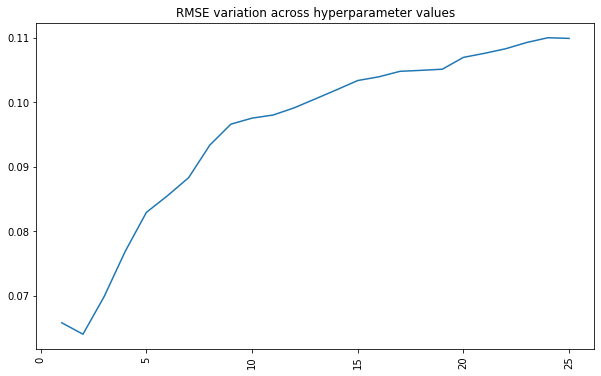

In [94]:
cols = df_cars.columns.to_list()[:-1]
plot_rmses(25,cols,folds=20)